# Gaussian Process Regression From Scratch

In this notebook we will use Julia to code
up Gaussian Process Regression (GPR) from scratch
i.e., without using any GPR library.

I did this to learn both GPR and Julia better.

A good reference is the Rasmussen Williams (2006) textbook available for free at http://www.gaussianprocess.org/

In particular Algorithm 2.1 is used.

## Imports

We start by importing the libraries we need.

This is a little different to python where
we like to do something like

`import numpy as np`

You can do this in Julia as

`import LinearAlgebra as LA`

But i'm not 100% of the different between `using` and `import` yet.

In [2]:
using Random
using Distributions
using LinearAlgebra
using Plots

# import Random
# import Distributions
# import LinearAlgebra as LA
# import Plots as plt

## Function Definitions

We need to define our covariance functions or kernels

$k(x, x') = \rm{cov}(f(x), f(x'))$

Where $x$ is our input space and $f(x)$ is our target function.

The covariance is a function of two input location and typically we will pass them to some kernel function and compute the distance between them with some weighting.

For example the squared-exponential (SE) kernel is given by

$$k_{SE}(\mathbf{x}, \mathbf{x}'; \sigma_f, \ell) = \sigma_f^2 \, \rm{exp}\,\left(-\frac{ |\mathbf{x} - \mathbf{x}'|^2 }{2 \ell} \right)$$

Where $\sigma_f^2$ is the signal variance and $\ell$ is a length scale.

This is also called a radial basis function (RBF) kernel.

$|\mathbf{x} - \mathbf{x}'|$ is the distance between the vectors $\mathbf{x}$ and $\mathbf{x}'$.

For this kernel the covariance is close to $1$ when $\mathbf{x}$ and $\mathbf{x}'$ are close and drops to $0$ when $\mathbf{x}$ and $\mathbf{x}'$ are far away.

We will calculate the squared distance by multiplying out the expression:

$$ |\mathbf{x} - \mathbf{x}'|^2 = |\mathbf{x} - \mathbf{x}'|^T \cdot |\mathbf{x} - \mathbf{x}'|$$

$$ |\mathbf{x} - \mathbf{x}'|^2 = \mathbf{x}^2 + {\mathbf{x}'^2}^T - 2 \mathbf{x} \cdot {\mathbf{x}'}^T $$

Where ${}^T$ is the transpose

Note we can also add in a noise variance $\sigma_n^2$ by adding a term to the kernel

$$ \sigma_n^2 \delta(\mathbf{x}, \mathbf{x}') $$

This term describes the observational noise at each of the data points. If we want to do interpolation we set $\sigma_n^2 = 0$

In [3]:
"""
computes |\vec{x1} - \vec{x2}|^2
"""
function compute_distance_squared(x1, x2)
    x1.^2 .+ (x2.^2)' .- 2.0 .* dot.(x1, x2')
end

compute_distance_squared

In [199]:
function squared_exponential_kernel(x1, x2, sigma_f, l)
    r_squared = compute_distance_squared(x1, x2)
    sigma_f^2 * exp.(-r_squared/(2.0*l))
end

squared_exponential_kernel (generic function with 1 method)

In [200]:
x_test = Vector(0:0.1:9);
# x_test = reshape(x_test, length(x_test), 1)

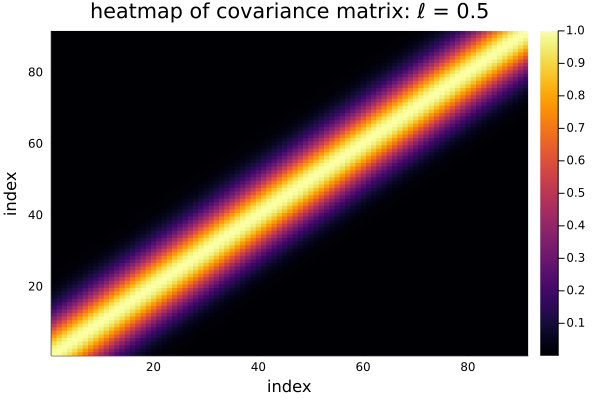

In [201]:
Plots.heatmap(squared_exponential_kernel(x_test, x_test, 1., 0.5))
Plots.title!("heatmap of covariance matrix: ℓ = 0.5")
Plots.xlabel!("index")
Plots.ylabel!("index")

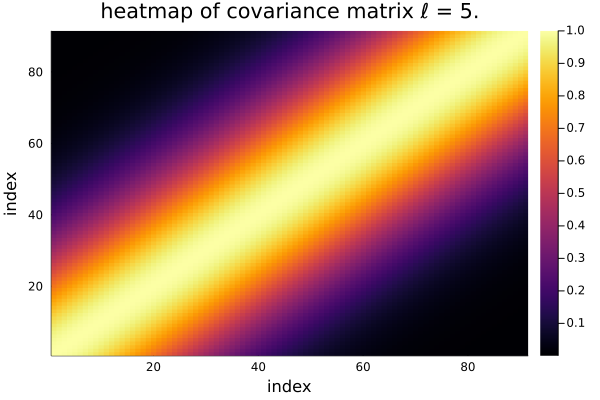

In [202]:
Plots.heatmap(squared_exponential_kernel(x_test, x_test, 1., 5.))
Plots.title!("heatmap of covariance matrix ℓ = 5.")
Plots.xlabel!("index")
Plots.ylabel!("index")

Above we see that as we increase the length scale $\ell$ then the diagonal band of high covariance becomes wider.

In [203]:
"""
would like to keep this general and just pass a kernel function
but I don't know how to do **kwargs in Julia
So for now the noly kernel function supported is going to be
the `squared_exponential_kernel`.
"""
function compute_covariance(x1, x2, kernel_fn; sigma_n=0., sigma_f=1., ell=1.)
    K = kernel_fn(x1, x2, sigma_f, ell)
    if float(sigma_n) != 0.
        K += sigma_n^2*I
    end
    K
end

compute_covariance

In [204]:
K = compute_covariance(x_test, x_test, squared_exponential_kernel, sigma_n=1e-3);

check that the covariance matrix is symmetric

In [205]:
issymmetric(K)

true

check that it is positive (semi-)definite

In [206]:
isposdef(K)

true

Note: I'm not sure if $\sigma_n$ is used correctly here. I use it to condition the covariance matrix to ensure that it is positive (semi-)definite

In [207]:
"""
Compute mean and covariance of test data conditioned
on the training data.
Algorithm 2.1 in R&W 2006
"""
function GPR(Xtest, Xtrain, ytrain; kernel_fn=squared_exponential_kernel, sigma_n=0., sigma_f=1., ell=1.)
    K = compute_covariance(Xtrain, Xtrain, kernel_fn, sigma_n=sigma_n, sigma_f=sigma_f, ell=ell)
    L = LinearAlgebra.cholesky(K + sigma_n*I)
    alpha = L.L' \ (L.L \ ytrain)
    k_s = compute_covariance(Xtrain, Xtest, kernel_fn, sigma_n=0., sigma_f=sigma_f, ell=ell)
    # mean prediction
    f_star = k_s' * alpha
    # covariance matrix prediction
    v = L.L \ k_s
    k_ss = compute_covariance(Xtest, Xtest, kernel_fn, sigma_n=0., sigma_f=sigma_f, ell=ell)
    var_fstar = k_ss - v'v
    
    # again because we need a positive semi-definite covariance matrix we add a small value to the diagonal.
    var_fstar_stablised = var_fstar + 1e-9*I
    Distributions.MvNormal(f_star, var_fstar_stablised), f_star, var_fstar_stablised
end

GPR

# Example Time

In [208]:
Xtrain = rand(Uniform(1, 10), 10)
ytrain = sin.(Xtrain);

In [209]:
Xtest = Vector(-5:0.1:15)
ytest = sin.(Xtest);

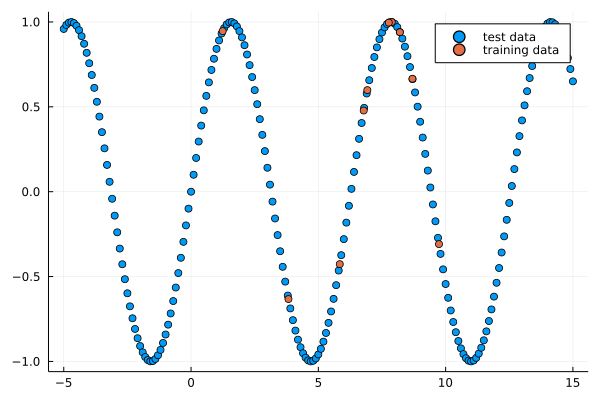

In [210]:
Plots.scatter(Xtest, ytest, label="test data")
Plots.scatter!(Xtrain, ytrain, label="training data")

In [211]:
gpr_dist, f_star, var_fstar = GPR(Xtest, Xtrain, ytrain; kernel_fn=squared_exponential_kernel, sigma_n=1e-3, sigma_f=1., ell=1.);

In [212]:
samples = rand(gpr_dist, 20);

In [213]:
size(samples)

(201, 20)

In [214]:
one_sigma = 1. * sqrt.(diag(var_fstar))
two_sigma = 2. * sqrt.(diag(var_fstar));

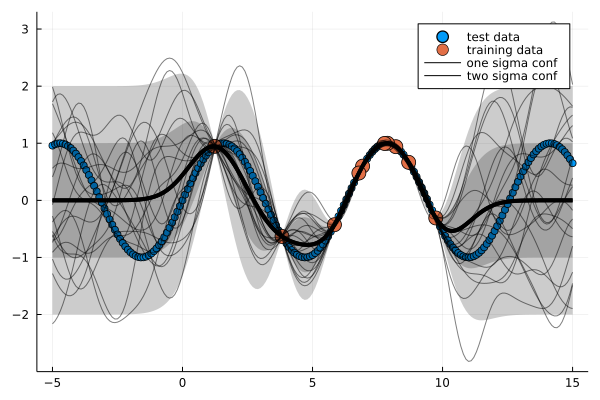

In [215]:
Plots.scatter(Xtest, ytest, label="test data")
Plots.scatter!(Xtrain, ytrain, label="training data", markersize=8)
Plots.plot!(Xtest, f_star, lw=4, ls=:solid, ribbon=one_sigma, fillalpha=0.2, fillcolor="black", color="black", label="one sigma conf")
Plots.plot!(Xtest, f_star, lw=4, ls=:solid, ribbon=two_sigma, fillalpha=0.2, fillcolor="black", color="black", label="two sigma conf")
Plots.plot!(Xtest, samples, color="black", label=nothing, α=0.5)

# Play around with hyper-parameters

In [216]:
function compute_and_plot_gpr(; sigma_n=1e-3, sigma_f=1., ell=1.)
    gpr_dist, f_star, var_fstar = GPR(Xtest, Xtrain, ytrain; kernel_fn=squared_exponential_kernel, sigma_n=sigma_n, sigma_f=sigma_f, ell=ell);
    samples = rand(gpr_dist, 20);
    one_sigma = 1. * sqrt.(diag(var_fstar))
    two_sigma = 2. * sqrt.(diag(var_fstar));

    Plots.scatter(Xtest, ytest, label="test data")
    Plots.scatter!(Xtrain, ytrain, label="training data", markersize=8)
    Plots.plot!(Xtest, f_star, lw=4, ls=:solid, ribbon=one_sigma, fillalpha=0.2, fillcolor="black", color="black", label="one sigma conf")
    Plots.plot!(Xtest, f_star, lw=4, ls=:solid, ribbon=two_sigma, fillalpha=0.2, fillcolor="black", color="black", label="two sigma conf")
    Plots.plot!(Xtest, samples, color="black", label=nothing, α=0.5)
    Plots.title!("sigma_n=$(sigma_n) , sigma_f=$(sigma_f), ell=$(ell)")
end

compute_and_plot_gpr (generic function with 4 methods)

### Varing $\ell$

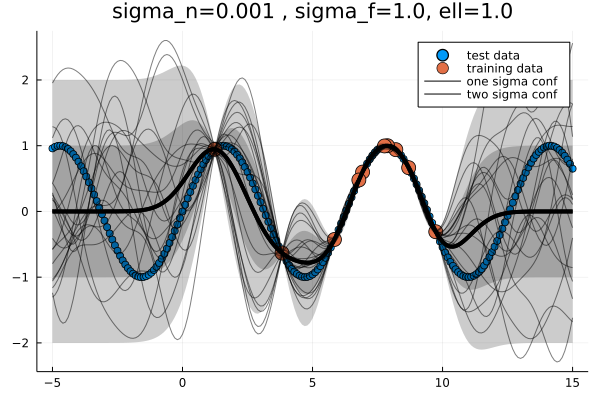

In [217]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=1., ell=1.)

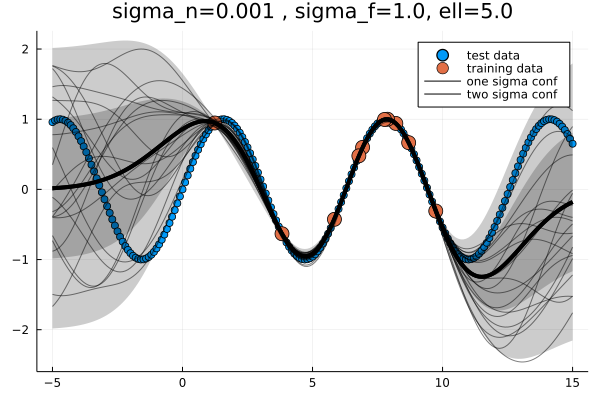

In [218]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=1., ell=5.)

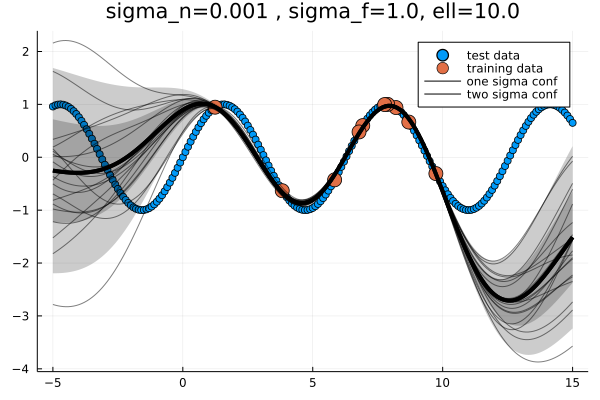

In [219]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=1., ell=10.)

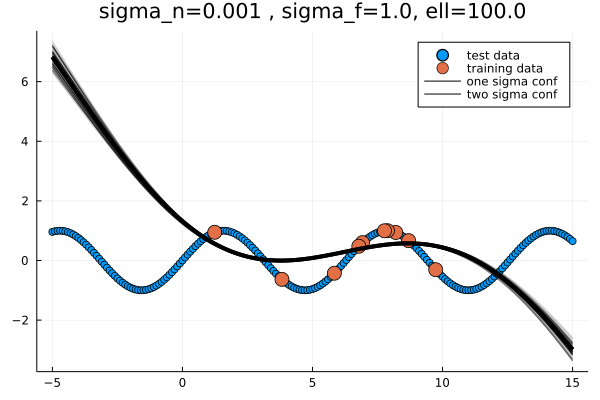

In [220]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=1., ell=100.)

### Varing $\sigma_f$

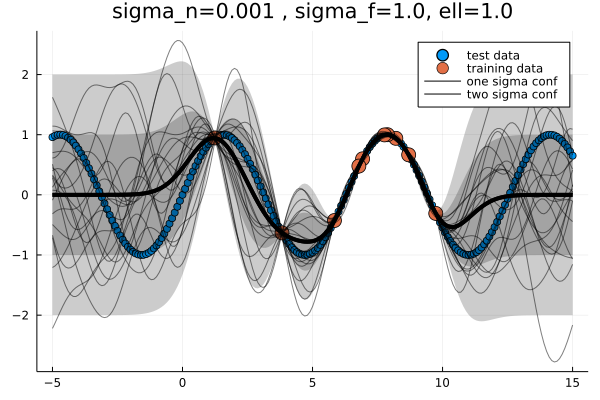

In [221]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=1., ell=1.)

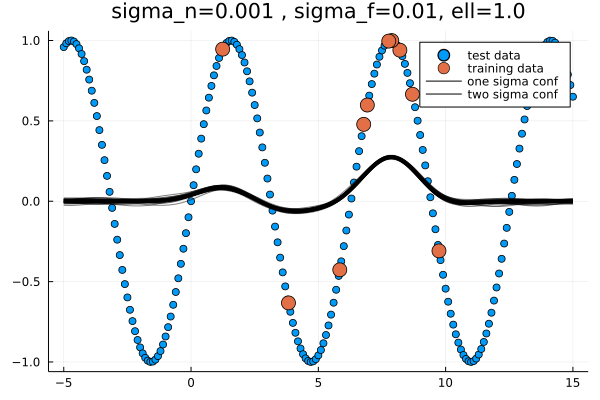

In [222]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=0.01, ell=1.)

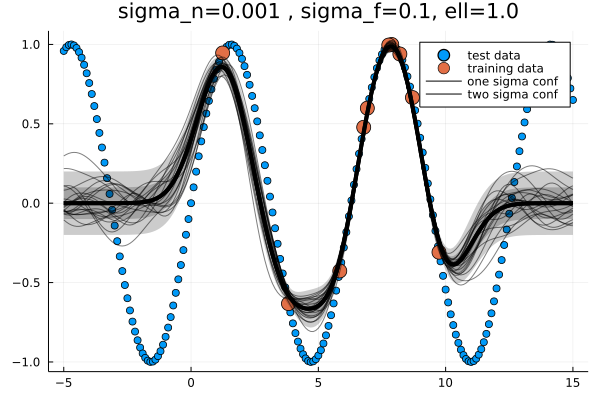

In [223]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=0.1, ell=1.)

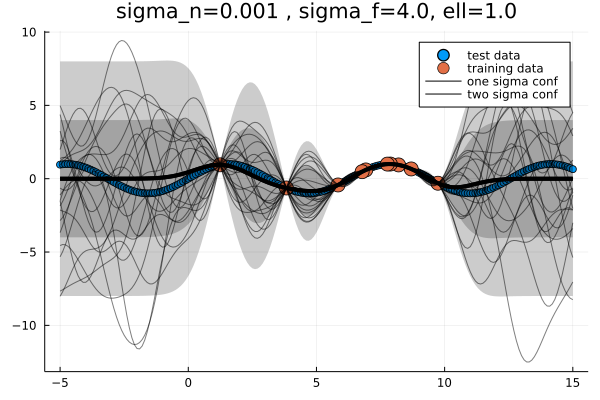

In [224]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=4., ell=1.)

### Varing $\sigma_n$

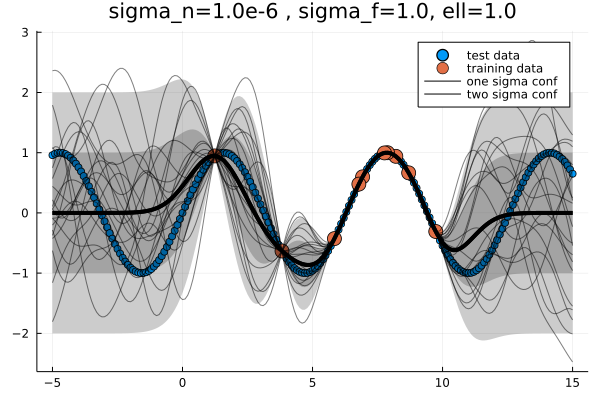

In [225]:
compute_and_plot_gpr(sigma_n=1e-6, sigma_f=1., ell=1.)

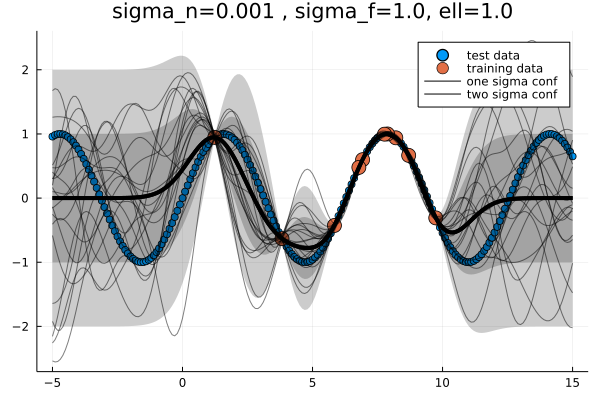

In [226]:
compute_and_plot_gpr(sigma_n=1e-3, sigma_f=1., ell=1.)

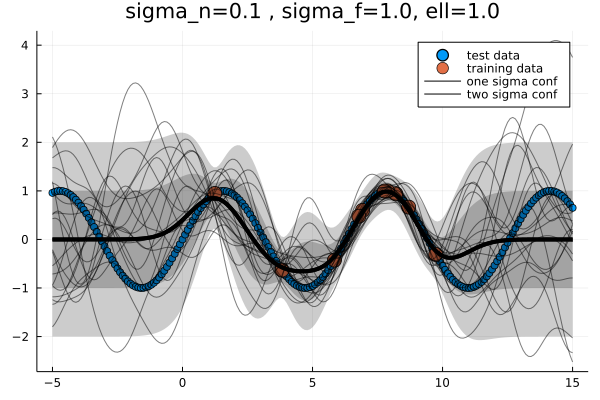

In [227]:
compute_and_plot_gpr(sigma_n=1e-1, sigma_f=1., ell=1.)

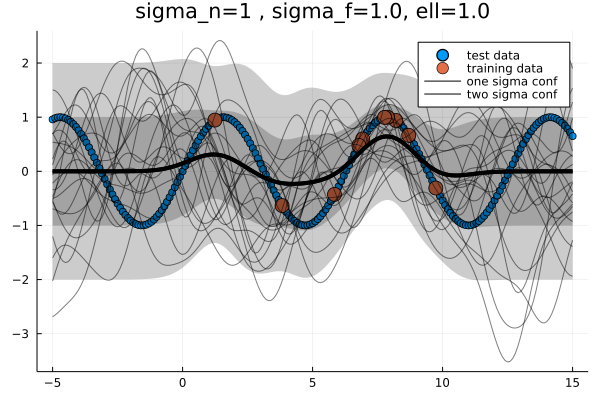

In [228]:
compute_and_plot_gpr(sigma_n=1, sigma_f=1., ell=1.)

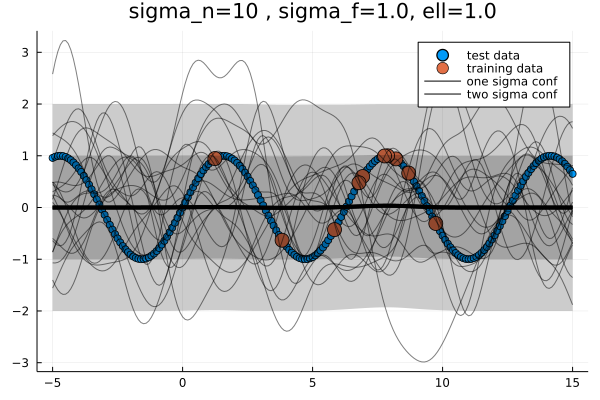

In [229]:
compute_and_plot_gpr(sigma_n=10, sigma_f=1., ell=1.)

Notice how outside the training data the uncertainty will tend towards the value of $\sigma_f$